In [1]:
import numpy as np
from scipy.sparse.linalg import expm_multiply, expm
import matplotlib.pyplot as plt
from qiskit.synthesis import SuzukiTrotter
from scipy.optimize import minimize, linprog
from scipy.linalg import eigh, eig
import random
import cmath

In [74]:
# pauli matrices
pauli = np.array([np.array([[1,0],[0,1]]), np.array([[0,1],[1,0]]), np.array([[0,-1.j],[1.j,0]]), np.array([[1,0],[0,-1]])])
pauli_tensor = np.array([[np.kron(pauli[i], pauli[j]) for i in range(4)] for j in range(4)])

# building operators 
def kronecker_pad(matrix, num_qubits, starting_site): 
    ''' pads a 1- or 2- local operator with identities on other sites to get 2^n by 2^n matrix '''
    kron_list = [np.eye(2) for i in range(num_qubits)]    
    kron_list[starting_site] = matrix
    if matrix.shape[0] == 4: 
        del kron_list[starting_site+1]
    
    padded_matrix = kron_list[0]
    for i in range(1, len(kron_list)):
        padded_matrix = np.kron(kron_list[i], padded_matrix)    
    return padded_matrix

# models
def heisenberg(num_qubits, bias_coeff=1.0, x_hopping_coeff=1.0, y_hopping_coeff=1.0, z_hopping_coeff=1.0): 
    terms = []
    for i in range(num_qubits): 
        bias = bias_coeff*kronecker_pad(pauli[3], num_qubits, i)
        terms.append(bias)
        
    for i in range(num_qubits-1): 
        z_hop = z_hopping_coeff*kronecker_pad(pauli_tensor[(3,3)], num_qubits, i)
        terms.append(z_hop)
        y_hop = y_hopping_coeff*kronecker_pad(pauli_tensor[(2,2)], num_qubits, i)
        terms.append(y_hop)
        x_hop = x_hopping_coeff*kronecker_pad(pauli_tensor[(1,1)], num_qubits, i)
        terms.append(x_hop)
    
    return sum(terms)

def xy(num_qubits, x_hopping_coeff=1.0, y_hopping_coeff=1.0):
    terms = []

    for i in range(num_qubits-1):
        x_hop = x_hopping_coeff*kronecker_pad(pauli_tensor[(1,1)], num_qubits, i)
        terms.append(x_hop)
        y_hop = x_hopping_coeff*kronecker_pad(pauli_tensor[(2,2)], num_qubits, i)
        terms.append(y_hop)

    return sum(terms)

n = 2
H = heisenberg(n)
# H = xy(n)

In [75]:
# def compute_Hkl(ref_states, Ham):
#     dim = len(ref_states)
#     Hkl = np.zeros((dim, dim), dtype=np.complex64)

#     for i in range(dim):
#         for j in range(dim):
#             Hkl[i][j] = (np.conj(ref_states[i]) @ Ham @ ref_states[j])
#     return Hkl

# def compute_S(ref_states):
#     dim = len(ref_states)
#     S = np.zeros((dim, dim), dtype=np.complex64)

#     for i in range(dim):
#         for j in range(dim):
#             S[i][j] = (np.conj(ref_states[i]) @ ref_states[j])
#     return S

def compute_Hkl(Ham, basis_set): 
    eff_H = np.eye(len(basis_set), dtype=complex)
    for i in range(len(basis_set)): 
        for j in range(len(basis_set)): 
            eff_H[i][j] = basis_set[i].conj().T @ Ham @ basis_set[j]
    return eff_H    

def compute_S(basis_set): 
    eff_S = np.eye(len(basis_set), dtype=complex)
    for i in range(len(basis_set)): 
        for j in range(len(basis_set)): 
            eff_S[i][j] = basis_set[i].conj().T @ basis_set[j]
    return eff_S

def random_initial_state(n):
    components = [complex(random.uniform(-1, 1), random.uniform(-1, 1)) for _ in range(n)]
    magnitude = cmath.sqrt(sum(comp.real**2 + comp.imag**2 for comp in components))
    normalized_vector = [comp / magnitude for comp in components]
    
    return np.array(normalized_vector)

In [88]:
tf = 10
ts = np.linspace(0, tf, 200)

# init = random_initial_state(2**n)

c = list("01") 
UnitVector = lambda c: np.eye(2**n)[c]
init = UnitVector(int(''.join(c), 2))

ref_states = [init]
added_indices = []
M = 8
num_ref_states = 1
tau = 0.1

expm_est = expm(-1j * tau * H) # should be trotterized really, eventually

for j in range(num_ref_states):
    for i in range(1, M):
        new_states = []
        new_states.append(expm_multiply(-1j * i * tau * H, ref_states[-1]))
        ref_states.extend(new_states)
    if (j < num_ref_states - 1):
        # should take second most probable if the first one is already in there
        xs = np.eye(2**n)
        # probs = [ np.abs(np.conj(x) @ ref_states[-1])**2 for x in xs]
        # ref_states.append(xs[np.argmax(probs)])

        sorted_probs_inds = np.argsort([np.abs(np.conj(x) @ ref_states[-1])**2 for x in xs])[::-1]
        for k in range(len(sorted_probs_inds)):
            if not (sorted_probs_inds[k] in added_indices):
                ref_states.append(xs[sorted_probs_inds[k]])
                added_indices.append(sorted_probs_inds[k])
                break

In [89]:
print(ref_states[2])

[0.        +0.j         0.78847323+0.24390335j 0.16686326-0.53942356j
 0.        +0.j        ]


In [90]:
Hkl = compute_Hkl(H, ref_states)
S = compute_S(ref_states)
print(S)

U, D, Vh = np.linalg.svd(S)
print(D)
eps = 1e-5
D[np.abs(D) < eps] = 0
D_inv = [1/d if d > 0 else 0 for d in D]
S_inv = Vh.conj().T @ np.diag(D_inv) @ U.conj().T

# c0 = np.linalg.inv(S) @ S[:,0]
c0 = np.zeros(len(ref_states))
c0[0] = 1
# c0

[[ 1.        +0.j          0.97517033+0.0978434j   0.78847323+0.24390335j
   0.29906676+0.20460258j -0.2248451 -0.35017549j -0.0700293 -0.98751255j
   0.24750627-0.42319773j -0.7307555 +0.25980538j]
 [ 0.97517033-0.0978434j   1.        +0.j          0.9027011 +0.18298657j
   0.47415988+0.25903472j -0.14123109-0.17797351j -0.16014684-0.92851275j
   0.27201173-0.59435646j -0.57380815+0.27125497j]
 [ 0.78847323-0.24390335j  0.9027011 -0.18298657j  1.        +0.j
   0.78847323+0.24390335j  0.12999804+0.10949584j -0.26720033-0.68727976j
   0.20374539-0.87330606j -0.22725415+0.16976392j]
 [ 0.29906676-0.20460258j  0.47415988-0.25903472j  0.78847323-0.24390335j
   1.        +0.j          0.64170937+0.27131037j -0.14123109-0.17797351j
  -0.0700293 -0.98751255j  0.18086574-0.24847752j]
 [-0.2248451 +0.35017549j -0.14123109+0.17797351j  0.12999804-0.10949584j
   0.64170937-0.27131037j  1.        +0.j          0.47415988+0.25903472j
  -0.26694182-0.52447653j  0.20374539-0.87330606j]
 [-0.0700293 

In [91]:
def QKFFEvolve(t, init):
    ct = expm(-1j * t * S_inv @ Hkl) @ init
    return sum([ct[i] * ref_states[i] for i in range(len(ct))])

# exact_te = [expm_multiply(-1j * H * t, init) for t in ts]
qkff_te = [QKFFEvolve(t, c0) for t in ts]

In [92]:
print(len(ref_states))
exact_final_te = expm_multiply(-1j * H * ts[-1], init)
qkff_final_te = QKFFEvolve(ts[-1], c0)
print(np.abs(np.conj(exact_final_te) @ qkff_final_te)**2)

8
0.9999999999999865


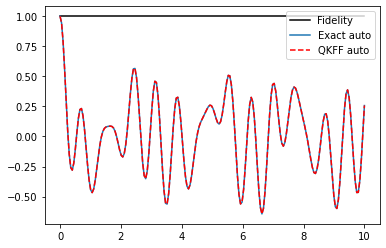

In [73]:
# O = np.kron(np.kron(np.kron(I,I),Z), np.kron(I,I))
# O = np.kron(Z,I)
# O = np.kron(Z, np.kron(I,I))

fidelity = [np.abs(np.conj(psi) @ phi)**2 for psi,phi in zip(exact_te, qkff_te)]


# exact_Z1 = [(np.conj(psi) @ O @ psi).real for psi in exact_te]
# qkff_Z1 = [(np.conj(psi) @ O @ psi).real for psi in qkff_te]

exact_auto = [(np.conj(init) @ psi).real for psi in exact_te]
qkff_auto = [(np.conj(init) @ psi).real for psi in qkff_te]


# plt.plot(ts, exact_Z1, label="Theoretical")
# plt.plot(ts, qkff_Z1, "r--", label="QKFF")
plt.plot(ts, fidelity, 'k', label="Fidelity")

plt.plot(ts, exact_auto, label="Exact auto")
plt.plot(ts, qkff_auto, "r--", label="QKFF auto")

# plt.plot(ts, qkff_Z1, 'r--', label="QKFF, R=1, M=6")
plt.legend(loc='upper right')